<h1>Experiments with feature detection algorithms</h1>

The goal is to test / develop algorithms for automated spectral line detection. These will eventually make their way into a specviz plug-in.

(from ticket #304):

The simplest useful detection algorithm is the following:

 - Convolve the spectrum with a fixed kernel (usually a Gaussian with FWHM corresponding to the spectral resolution).
 - Divide by the RMS noise and search for pixels above or below a fixed S/N threshold. These are the emission or absorption line centers.


What would be the main product of a peak-find algorithm in specviz? Just the markers on screen? A list of positions? Some coupling with the line list tool?

<h4>Algorithms included in this script</h4>

- simplest (above)
- first derivative zero-crossings
- nmrglue.peakpick
- peakdet from MatLab
- SciPy's wavelet-based approach
- PeakUtils' indexes
- detect_peaks (supposedly identical with MatLab's findpeaks)
- SciPy's argrelmin, argrelmax

In [1]:
import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt

%matplotlib inline
# constants for all plots
x_label = '$\lambda$($\AA$)'
y_label = 'erg.cm$^{-2}$.s$^{-1}$.$A^{-1}$'
SIZE = (16, 3)
xmin = 1130.
xmax = 1480.
zero_line = [(xmin, xmax),(0.,0.)]

<h3>Get raw data</h3>

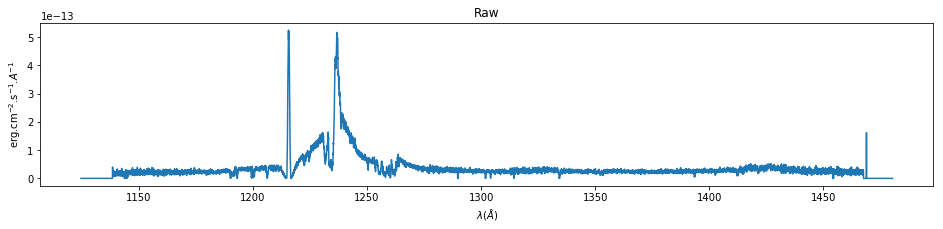

In [2]:
hdulist = fits.open('data/combined_13330_G130M_v40_bin4.fits')
flux = hdulist[1].data['flux'][0]
wave = hdulist[1].data['wavelength'][0]

plt.figure(figsize=SIZE)
plt.plot(wave, flux)
plt.xlabel(x_label)
plt.ylabel(y_label)
plt.title('Raw')

<h3>Simplest algorithm</h3>

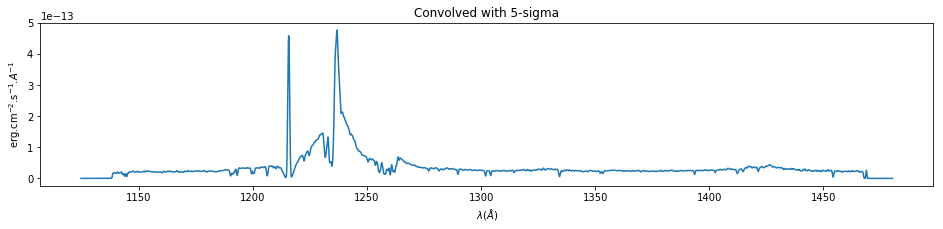

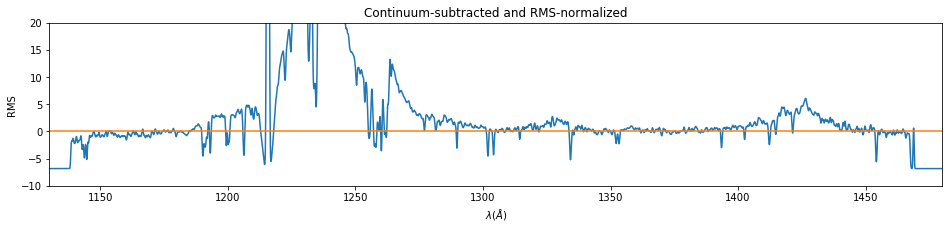

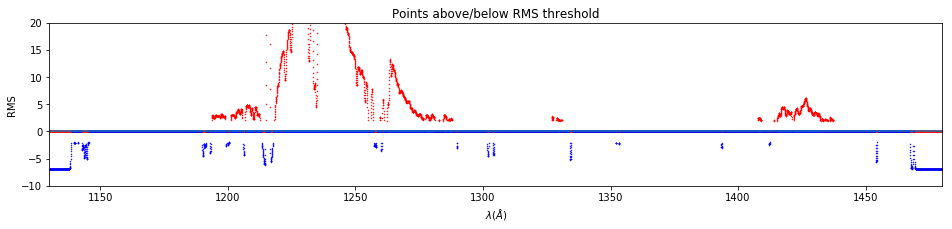

In [3]:
# Convolution
#
STDDEV = 5

from astropy.convolution import convolve, Gaussian1DKernel
gauss = Gaussian1DKernel(stddev=STDDEV)
convolved_flux = convolve(flux, gauss)

plt.figure(figsize=SIZE)
plt.plot(wave, convolved_flux)
plt.xlabel(x_label)
plt.ylabel(y_label)
plt.title('Convolved with ' + str(STDDEV) + '-sigma')

# Normalize by RMS noise.
# 
# Do the dumb thing and pick a region by eye. 
# A real-world implementation should do better 
# than that.
indices = (wave > 1360.) & (wave < 1380.) 
f1 = flux[indices]
mean = np.median(f1) # median is less affected by outliers
rms = np.std(f1)

normalized_flux = (convolved_flux - mean) / rms

plt.figure(figsize=SIZE)
plt.plot(wave, normalized_flux)
plt.plot(zero_line[0], zero_line[1])
plt.axis([xmin, xmax, -10., 20.])
plt.xlabel(x_label)
plt.ylabel('RMS')
plt.title('Continuum-subtracted and RMS-normalized')

# Search for points above and below a threshold.
threshold = 2.

out = np.where(normalized_flux < threshold)
normalized_flux[out] = 0.

normalized_flux_2 = (convolved_flux - mean) / rms
out = np.where(normalized_flux_2 > -threshold)
normalized_flux_2[out] = 0.

plt.figure(figsize=SIZE)
plt.plot(wave, normalized_flux, '.', color='r', markersize=1)
plt.plot(wave, normalized_flux_2, '.', color='b', markersize=1)
plt.plot(zero_line[0], zero_line[1])
plt.axis([xmin, xmax, -10., 20.])
plt.xlabel(x_label)
plt.ylabel('RMS')
plt.title('Points above/below RMS threshold')

<h3>First derivative zero-crossings</h3>

A better algorithm may be one that looks for the first derivative zero crossings. That way, slow fluctuations along the spectrum are cancelled out and the detection becomes local. 

We will give a shot at this one: https://terpconnect.umd.edu/~toh/spectrum/PeakFindingandMeasurement.htm 

with Matlab code in here: https://terpconnect.umd.edu/~toh/spectrum/findpeaksx.m

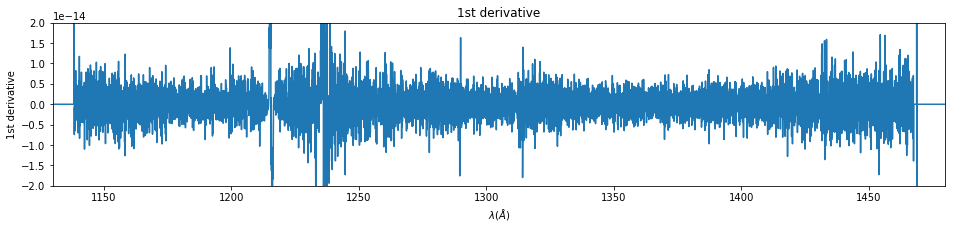

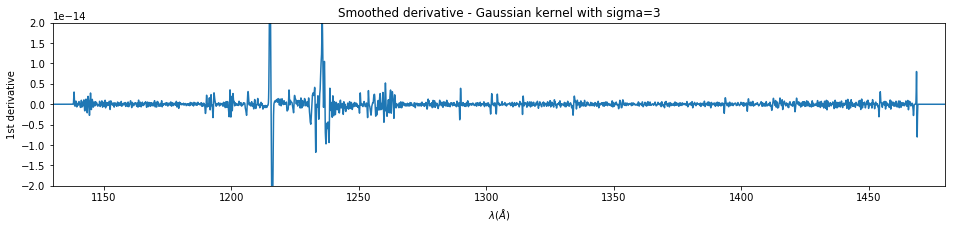

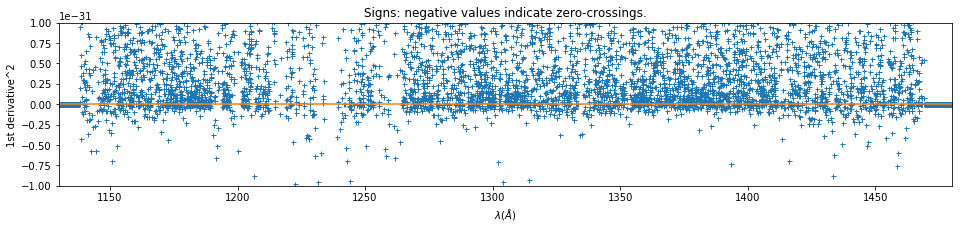

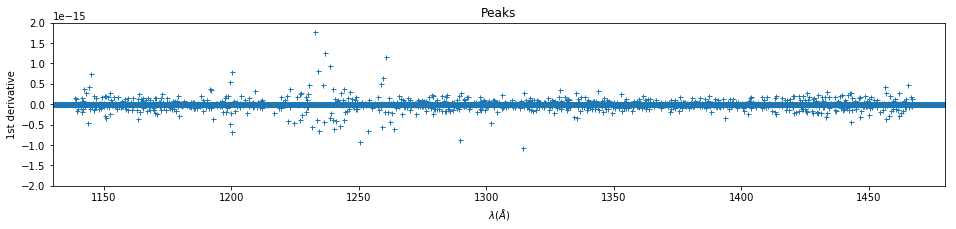

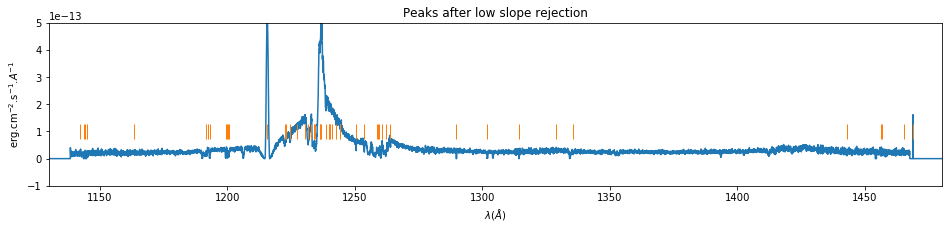

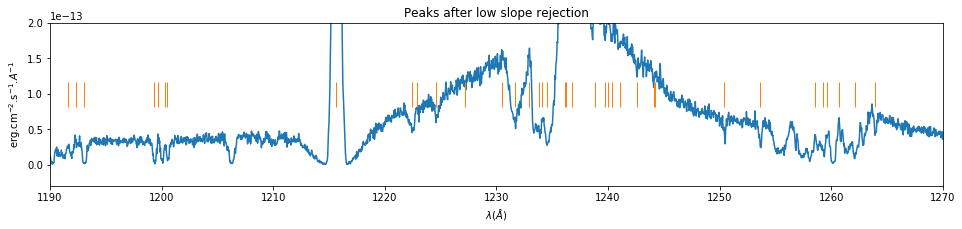

In [4]:
# 1st derivative
deriv = np.gradient(flux)

plt.figure(figsize=SIZE)
plt.plot(wave, deriv)
plt.axis([xmin, xmax, -2.e-14, 2.e-14])
plt.xlabel(x_label)
plt.ylabel('1st derivative')
plt.title('1st derivative')

# smooth it - gaussian stddev is a free parameter
STDDEV = 3
gauss = Gaussian1DKernel(stddev=STDDEV)
smooth_deriv = convolve(deriv, gauss)

plt.figure(figsize=SIZE)
plt.plot(wave, smooth_deriv)
plt.axis([xmin, xmax, -2.e-14, 2.e-14])
plt.xlabel(x_label)
plt.ylabel('1st derivative')
plt.title('Smoothed derivative - Gaussian kernel with sigma=' + str(STDDEV))

# detect zero crossings
# first, we locate where the derivative changes sign.
signs = smooth_deriv[:-1] * smooth_deriv[1:]

plt.figure(figsize=SIZE)
plt.plot(wave[1:], signs, '+', markersize=5)
plt.plot(zero_line[0], zero_line[1])
plt.axis([xmin, xmax, -1.e-31, 1.e-31])
plt.xlabel(x_label)
plt.ylabel('1st derivative^2')
plt.title('Signs: negative values indicate zero-crossings.')

# peaks are located at the zero-crossings
crossings = np.where(signs <= 0)
non_crossings = np.where(signs > 0)

peak_values = smooth_deriv.copy()
peak_values[non_crossings] = 0.

plt.figure(figsize=SIZE)
plt.plot(wave, peak_values, '+', markersize=5)
plt.axis([xmin, xmax, -2.e-15, 2.e-15])
plt.xlabel(x_label)
plt.ylabel('1st derivative')
plt.title('Peaks')

# slope threshold - free parameter. 
# we arbitrarily pick as theshold 10% of the 
# maximum slope found in the smoothed derivatives.
SLOPE_THRESHOLD = 0.1

max_slope = np.max(smooth_deriv[crossings])
reject = np.where(np.abs(peak_values) < max_slope * SLOPE_THRESHOLD)
peak_values[reject] = 0.

# create markers and plot them
markers = np.full(peak_values.shape, -100.)
markers[np.where(np.abs(peak_values) > 0.)] = 1.e-13

plt.figure(figsize=SIZE)
plt.plot(wave, flux)
plt.plot(wave, markers, '|', markersize=15)
plt.axis([xmin, xmax, -1.e-13, 5.e-13])
plt.xlabel(x_label)
plt.ylabel(y_label)
plt.title('Peaks after low slope rejection')
plt.figure(figsize=SIZE)
plt.plot(wave, flux)
plt.plot(wave, markers, '|', markersize=25)
plt.axis([1190., 1270., -0.3e-13, 2.e-13])
plt.xlabel(x_label)
plt.ylabel(y_label)
plt.title('Peaks after low slope rejection')

Lets try the same algorithm but starting with smoothed flux data.

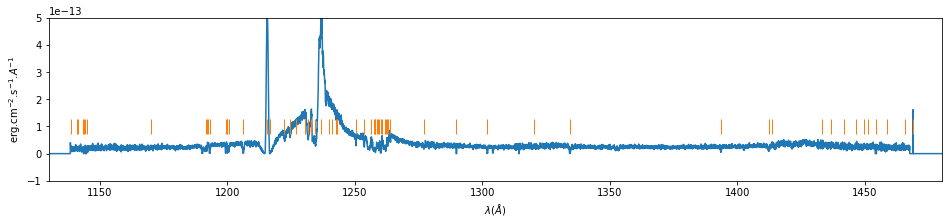

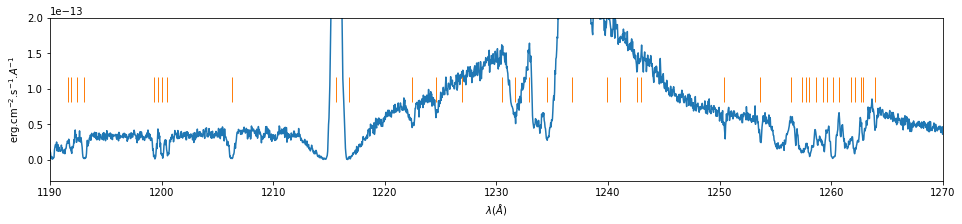

In [5]:
DATA_SMOOTH_STDDEV = 3
DERIVATIVE_SMOOTH_STDDEV = 3
SLOPE_THRESHOLD = 0.1

gauss = Gaussian1DKernel(stddev=DATA_SMOOTH_STDDEV)
convolved_flux = convolve(flux, gauss)
deriv = np.gradient(convolved_flux)
gauss = Gaussian1DKernel(stddev=DERIVATIVE_SMOOTH_STDDEV)
smooth_deriv = convolve(deriv, gauss)
signs = smooth_deriv[:-1] * smooth_deriv[1:]
crossings = np.where(signs <= 0)
non_crossings = np.where(signs > 0)
peak_values = smooth_deriv.copy()
peak_values[non_crossings] = 0.
max_slope = np.max(smooth_deriv[crossings])
reject = np.where(np.abs(peak_values) < max_slope * SLOPE_THRESHOLD)
peak_values[reject] = 0.

markers = np.full(peak_values.shape, -100.)
markers[np.where(np.abs(peak_values) > 0.)] = 1.e-13

plt.figure(figsize=SIZE)
plt.plot(wave, flux)
plt.plot(wave, markers, '|', markersize=15)
plt.axis([xmin, xmax, -1.e-13, 5.e-13])
plt.xlabel(x_label)
plt.ylabel(y_label)
plt.figure(figsize=SIZE)
plt.plot(wave, flux)
plt.plot(wave, markers, '|', markersize=25)
plt.axis([1190., 1270., -0.3e-13, 2.e-13])
plt.xlabel(x_label)
plt.ylabel(y_label)

This derivative-based algorithm seems to work better than the simplest one tried first, but is sensitive to input parameters. 

It can be perfected (I think) to tell apart maxima from minima. 

<h3>nmrglue.peakpick</h3>

Tried nmrglue.peakpick.pick. From http://nmrglue.readthedocs.io/en/latest/index.html. Requires special format for data set.

<h3>peakdet from MATLAB</h3>

https://gist.github.com/endolith/250860. 

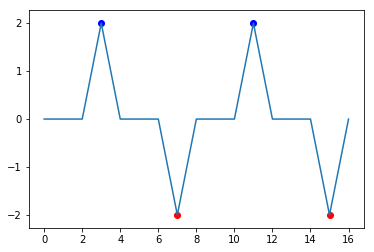

In [6]:
import sys
from numpy import NaN, Inf, arange, isscalar, asarray, array

def peakdet(v, delta, x = None):
    """
    Converted from MATLAB script at http://billauer.co.il/peakdet.html
    
    Returns two arrays
    
    function [maxtab, mintab]=peakdet(v, delta, x)
    %PEAKDET Detect peaks in a vector
    %        [MAXTAB, MINTAB] = PEAKDET(V, DELTA) finds the local
    %        maxima and minima ("peaks") in the vector V.
    %        MAXTAB and MINTAB consists of two columns. Column 1
    %        contains indices in V, and column 2 the found values.
    %      
    %        With [MAXTAB, MINTAB] = PEAKDET(V, DELTA, X) the indices
    %        in MAXTAB and MINTAB are replaced with the corresponding
    %        X-values.
    %
    %        A point is considered a maximum peak if it has the maximal
    %        value, and was preceded (to the left) by a value lower by
    %        DELTA.
    
    % Eli Billauer, 3.4.05 (Explicitly not copyrighted).
    % This function is released to the public domain; Any use is allowed.
    
    """
    maxtab = []
    mintab = []
       
    if x is None:
        x = arange(len(v))
    
    v = asarray(v)
    
    if len(v) != len(x):
        sys.exit('Input vectors v and x must have same length')
    
    if not isscalar(delta):
        sys.exit('Input argument delta must be a scalar')
    
    if delta <= 0:
        sys.exit('Input argument delta must be positive')
    
    mn, mx = Inf, -Inf
    mnpos, mxpos = NaN, NaN
    
    lookformax = True
    
    for i in arange(len(v)):
        this = v[i]
        if this > mx:
            mx = this
            mxpos = x[i]
        if this < mn:
            mn = this
            mnpos = x[i]
        
        if lookformax:
            if this < mx-delta:
                maxtab.append((mxpos, mx))
                mn = this
                mnpos = x[i]
                lookformax = False
        else:
            if this > mn+delta:
                mintab.append((mnpos, mn))
                mx = this
                mxpos = x[i]
                lookformax = True

    return array(maxtab), array(mintab)

if __name__=="__main__":
    from matplotlib.pyplot import plot, scatter, show
    series = [0,0,0,2,0,0,0,-2,0,0,0,2,0,0,0,-2,0]
    maxtab, mintab = peakdet(series,.3)
    plot(series)
    scatter(array(maxtab)[:,0], array(maxtab)[:,1], color='blue')
    scatter(array(mintab)[:,0], array(mintab)[:,1], color='red')
    show()

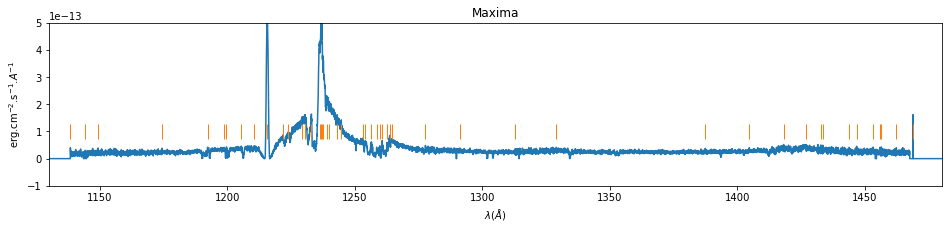

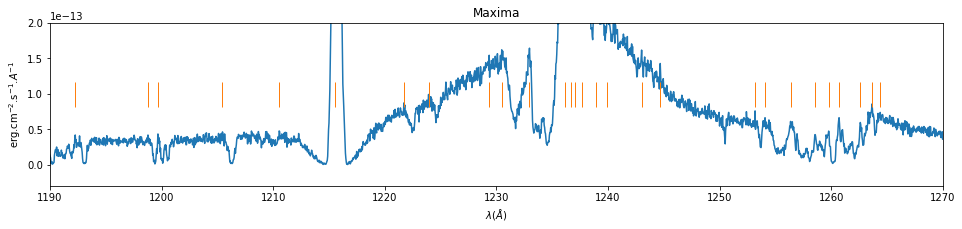

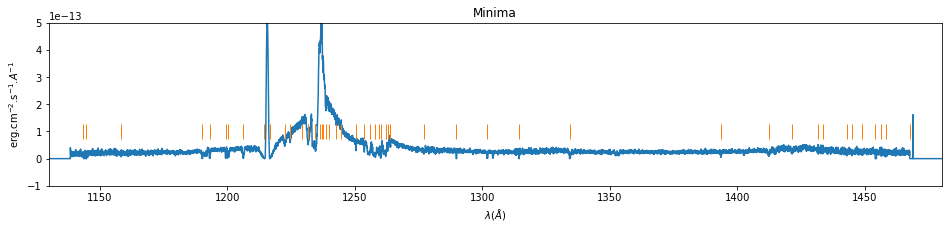

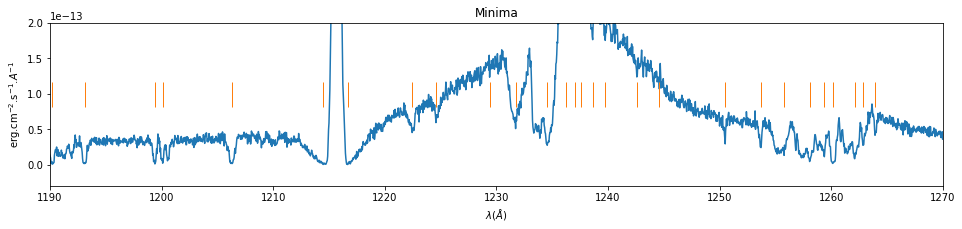

In [7]:
max_peaks, min_peaks = peakdet(flux, 3.E-14)
# max_peaks, min_peaks = peakdet(convolved_flux, 8.E-15)

max_peak_indices = np.ndarray.astype(max_peaks[:,[0]], int)
min_peak_indices = np.ndarray.astype(min_peaks[:,[0]], int)

max_markers = np.full(convolved_flux.shape, -100.)
min_markers = np.full(convolved_flux.shape, -100.)

max_markers[max_peak_indices] = 1.e-13
min_markers[min_peak_indices] = 1.e-13

plt.figure(figsize=SIZE)
plt.plot(wave, flux)
plt.plot(wave, max_markers, '|', markersize=15)
plt.axis([xmin, xmax, -1.e-13, 5.e-13])
plt.xlabel(x_label)
plt.ylabel(y_label)
plt.title('Maxima')

plt.figure(figsize=SIZE)
plt.plot(wave, flux)
plt.plot(wave, max_markers, '|', markersize=25)
plt.axis([1190., 1270., -0.3e-13, 2.e-13])
plt.xlabel(x_label)
plt.ylabel(y_label)
plt.title('Maxima')

plt.figure(figsize=SIZE)
plt.plot(wave, flux)
plt.plot(wave, min_markers, '|', markersize=15)
plt.axis([xmin, xmax, -1.e-13, 5.e-13])
plt.xlabel(x_label)
plt.ylabel(y_label)
plt.title('Minima')

plt.figure(figsize=SIZE)
plt.plot(wave, flux)
plt.plot(wave, min_markers, '|', markersize=25)
plt.axis([1190., 1270., -0.3e-13, 2.e-13])
plt.xlabel(x_label)
plt.ylabel(y_label)
plt.title('Minima')

Sounds good, although it is sensitive to the value of 'delta'. Using smoothed data doesn't make much of a difference. 

<h3>SciPy's wavelet-based approach</h3>

Uses wavelet smoothing. Finds relative maxima which appear at enough length scales, and with sufficiently high SNR.  

https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.signal.find_peaks_cwt.html

/Users/busko/Projects/software/miniconda3_specviz/envs/jupyter/lib/python3.6/site-packages/scipy/signal/_peak_finding.py:412: RuntimeWarning: divide by zero encountered in double_scalars
  snr = abs(cwt[line[0][0], line[1][0]] / noises[line[1][0]])


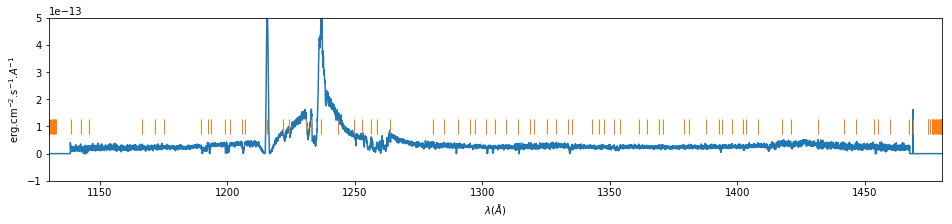

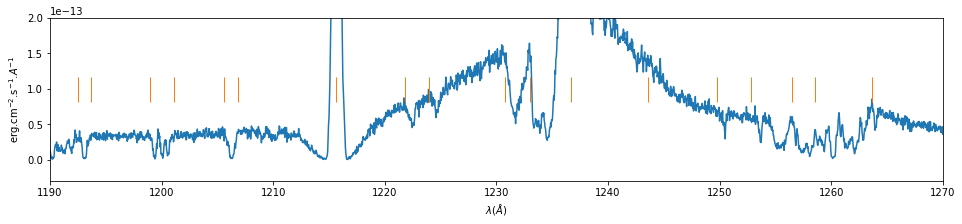

In [8]:
from scipy.signal import find_peaks_cwt

scales = np.arange(1, 100)
peaks = find_peaks_cwt(flux, scales)

markers = np.full(flux.shape, -100.)
markers[peaks] = 1.e-13

plt.figure(figsize=SIZE)
plt.plot(wave, flux)
plt.plot(wave, markers, '|', markersize=15)
plt.axis([xmin, xmax, -1.e-13, 5.e-13])
plt.xlabel(x_label)
plt.ylabel(y_label)

plt.figure(figsize=SIZE)
plt.plot(wave, flux)
plt.plot(wave, markers, '|', markersize=25)
plt.axis([1190., 1270., -0.3e-13, 2.e-13])
plt.xlabel(x_label)
plt.ylabel(y_label)

This only works for maxima. Again, no way to tell which is the optimal smoothing.

<h3>PeakUtils package</h3>

https://bitbucket.org/lucashnegri/peakutils

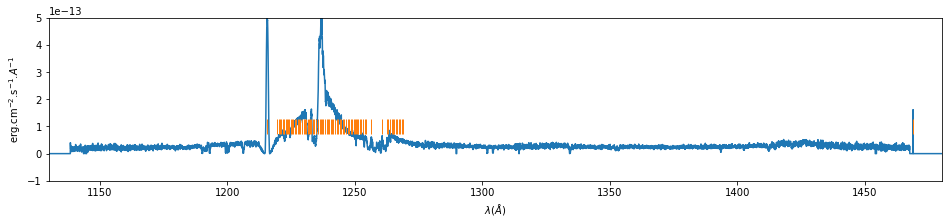

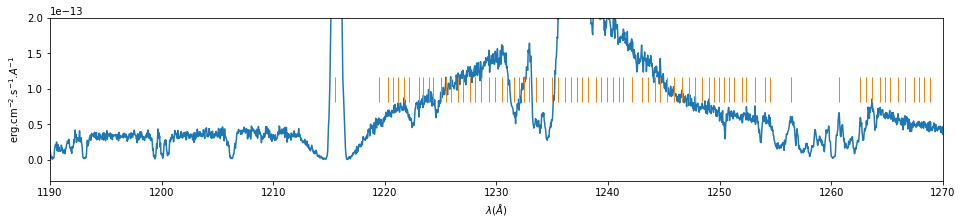

In [9]:
import peakutils

peaks = peakutils.indexes(flux, thres=0.1, min_dist=10)

markers = np.full(flux.shape, -100.)
markers[peaks] = 1.e-13

plt.figure(figsize=SIZE)
plt.plot(wave, flux)
plt.plot(wave, markers, '|', markersize=15)
plt.axis([xmin, xmax, -1.e-13, 5.e-13])
plt.xlabel(x_label)
plt.ylabel(y_label)

plt.figure(figsize=SIZE)
plt.plot(wave, flux)
plt.plot(wave, markers, '|', markersize=25)
plt.axis([1190., 1270., -0.3e-13, 2.e-13])
plt.xlabel(x_label)
plt.ylabel(y_label)

This apparently only works for maxima. No documentation. Doesn't look good enough.

<h3>detect_peaks</h3>

Supposedly identical with MatLab's findpeaks function. 

https://github.com/demotu/BMC/blob/master/functions/detect_peaks.py

In [10]:
def detect_peaks(x, mph=None, mpd=1, threshold=0, edge='rising',
                 kpsh=False, valley=False, show=False, ax=None):
    x = np.atleast_1d(x).astype('float64')
    if x.size < 3:
        return np.array([], dtype=int)
    if valley:
        x = -x
    # find indices of all peaks
    dx = x[1:] - x[:-1]
    # handle NaN's
    indnan = np.where(np.isnan(x))[0]
    if indnan.size:
        x[indnan] = np.inf
        dx[np.where(np.isnan(dx))[0]] = np.inf
    ine, ire, ife = np.array([[], [], []], dtype=int)
    if not edge:
        ine = np.where((np.hstack((dx, 0)) < 0) & (np.hstack((0, dx)) > 0))[0]
    else:
        if edge.lower() in ['rising', 'both']:
            ire = np.where((np.hstack((dx, 0)) <= 0) & (np.hstack((0, dx)) > 0))[0]
        if edge.lower() in ['falling', 'both']:
            ife = np.where((np.hstack((dx, 0)) < 0) & (np.hstack((0, dx)) >= 0))[0]
    ind = np.unique(np.hstack((ine, ire, ife)))
    # handle NaN's
    if ind.size and indnan.size:
        # NaN's and values close to NaN's cannot be peaks
        ind = ind[np.in1d(ind, np.unique(np.hstack((indnan, indnan-1, indnan+1))), invert=True)]
    # first and last values of x cannot be peaks
    if ind.size and ind[0] == 0:
        ind = ind[1:]
    if ind.size and ind[-1] == x.size-1:
        ind = ind[:-1]
    # remove peaks < minimum peak height
    if ind.size and mph is not None:
        ind = ind[x[ind] >= mph]
    # remove peaks - neighbors < threshold
    if ind.size and threshold > 0:
        dx = np.min(np.vstack([x[ind]-x[ind-1], x[ind]-x[ind+1]]), axis=0)
        ind = np.delete(ind, np.where(dx < threshold)[0])
    # detect small peaks closer than minimum peak distance
    if ind.size and mpd > 1:
        ind = ind[np.argsort(x[ind])][::-1]  # sort ind by peak height
        idel = np.zeros(ind.size, dtype=bool)
        for i in range(ind.size):
            if not idel[i]:
                # keep peaks with the same height if kpsh is True
                idel = idel | (ind >= ind[i] - mpd) & (ind <= ind[i] + mpd) \
                    & (x[ind[i]] > x[ind] if kpsh else True)
                idel[i] = 0  # Keep current peak
        # remove the small peaks and sort back the indices by their occurrence
        ind = np.sort(ind[~idel])
    return ind

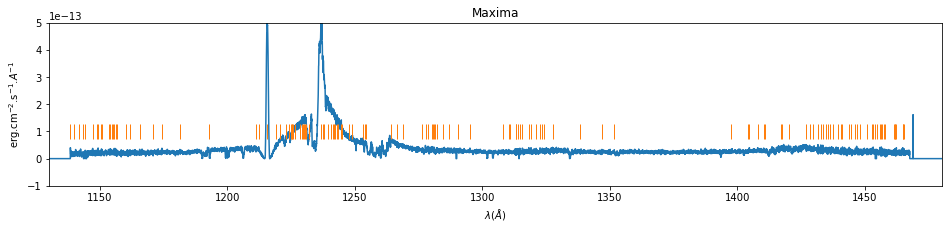

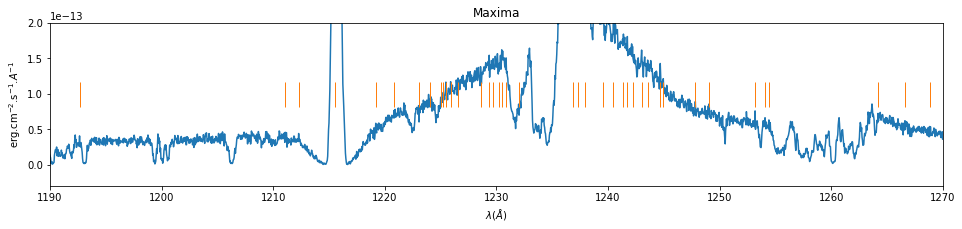

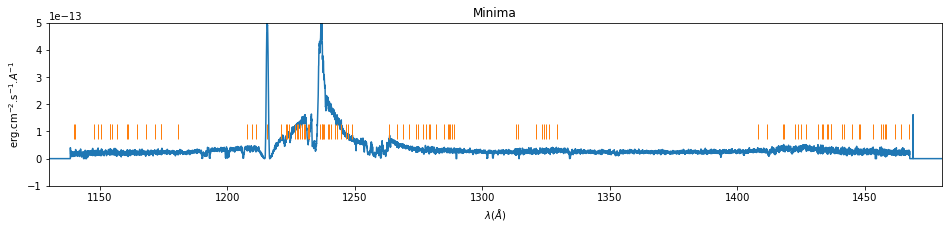

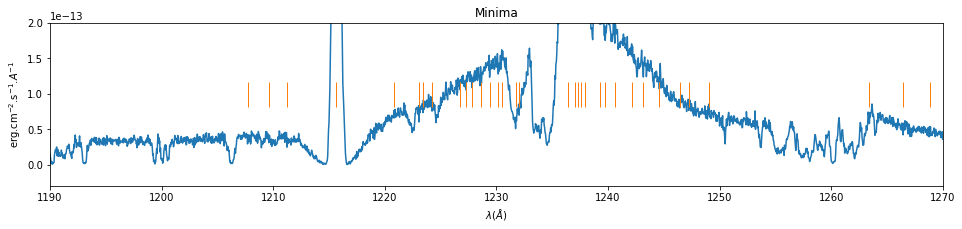

In [11]:
peaks = detect_peaks(flux, threshold=1.E-14, mpd=5)
valleys = detect_peaks(flux, valley=True, threshold=1.E-14, mpd=5)

max_markers = np.full(flux.shape, -100.)
min_markers = np.full(flux.shape, -100.)
max_markers[peaks] = 1.e-13
min_markers[valleys] = 1.e-13

plt.figure(figsize=SIZE)
plt.plot(wave, flux)
plt.plot(wave, max_markers, '|', markersize=15)
plt.axis([xmin, xmax, -1.e-13, 5.e-13])
plt.xlabel(x_label)
plt.ylabel(y_label)
plt.title('Maxima')

plt.figure(figsize=SIZE)
plt.plot(wave, flux)
plt.plot(wave, max_markers, '|', markersize=25)
plt.axis([1190., 1270., -0.3e-13, 2.e-13])
plt.xlabel(x_label)
plt.ylabel(y_label)
plt.title('Maxima')

plt.figure(figsize=SIZE)
plt.plot(wave, flux)
plt.plot(wave, min_markers, '|', markersize=15)
plt.axis([xmin, xmax, -1.e-13, 5.e-13])
plt.xlabel(x_label)
plt.ylabel(y_label)
plt.title('Minima')

plt.figure(figsize=SIZE)
plt.plot(wave, flux)
plt.plot(wave, min_markers, '|', markersize=25)
plt.axis([1190., 1270., -0.3e-13, 2.e-13])
plt.xlabel(x_label)
plt.ylabel(y_label)
plt.title('Minima')

Very sensitive to the threshold value. Erratic detection.

<h3>SciPy's argrelmin, argrelmax</h3>

https://docs.scipy.org/doc/scipy-0.14.0/reference/signal.html

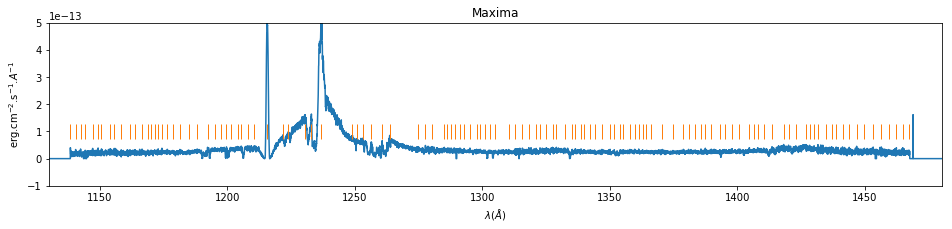

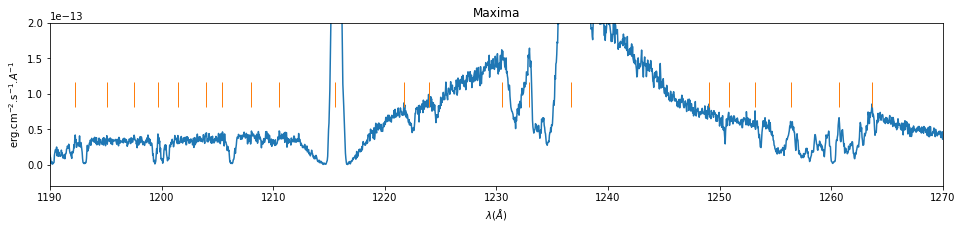

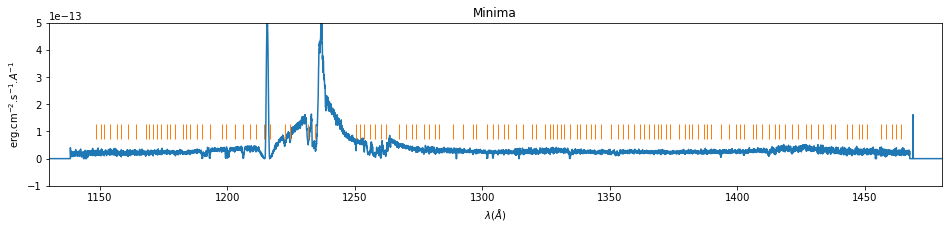

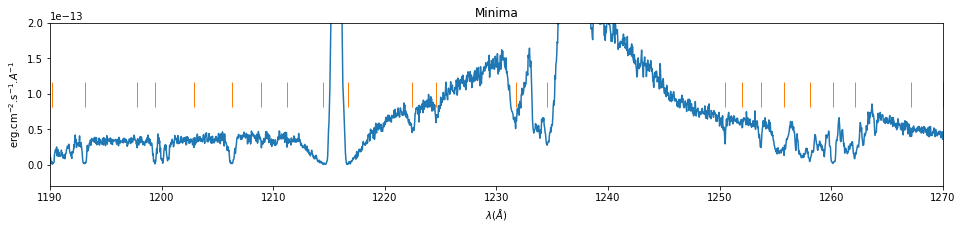

In [12]:
from scipy.signal import argrelmin, argrelmax

mins = argrelmin(flux, order=30)
maxs = argrelmax(flux, order=30)

max_markers = np.full(flux.shape, -100.)
min_markers = np.full(flux.shape, -100.)
max_markers[maxs] = 1.e-13
min_markers[mins] = 1.e-13

plt.figure(figsize=SIZE)
plt.plot(wave, flux)
plt.plot(wave, max_markers, '|', markersize=15)
plt.axis([xmin, xmax, -1.e-13, 5.e-13])
plt.xlabel(x_label)
plt.ylabel(y_label)
plt.title('Maxima')

plt.figure(figsize=SIZE)
plt.plot(wave, flux)
plt.plot(wave, max_markers, '|', markersize=25)
plt.axis([1190., 1270., -0.3e-13, 2.e-13])
plt.xlabel(x_label)
plt.ylabel(y_label)
plt.title('Maxima')

plt.figure(figsize=SIZE)
plt.plot(wave, flux)
plt.plot(wave, min_markers, '|', markersize=15)
plt.axis([xmin, xmax, -1.e-13, 5.e-13])
plt.xlabel(x_label)
plt.ylabel(y_label)
plt.title('Minima')

plt.figure(figsize=SIZE)
plt.plot(wave, flux)
plt.plot(wave, min_markers, '|', markersize=25)
plt.axis([1190., 1270., -0.3e-13, 2.e-13])
plt.xlabel(x_label)
plt.ylabel(y_label)
plt.title('Minima')

Sounds good. One free parameter.

<h2>Summary</h2>

| Algorithm                         | Good?        | # user parameters  | max/min?      | Notes               | 
|:----------------------------------|:-------------|:-------------------|:--------------|:-------------------:|
| simplest                          | no           | 1+                 | yes           |                     |
| nmrglue.peakpick                  |              |                    |               | special data format |
| 1st derivative zero-crossings     | yes          | 3                  | both together | max/min possible    | 
| SciPy's wavelet-based             | yes          | 1+                 | max           |                     | 
| SciPy's argrelmin, argrelmax      | yes          | 1                  | yes           |                     |
| peakdet from MatLab               | yes          | 1                  | yes           | sensitive to param. |
| detect_peaks (MatLab's findpeaks) | no           | 2                  | yes           |                     |
| PeakUtils' indexes                | no           | 2                  | max?          |                     | 





